[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Przewidywane ceny: [141.97443321 142.86199863 140.42994272 143.10370658]
Rzeczywiste ceny: [145.42999268 150.82000732 154.5       ]


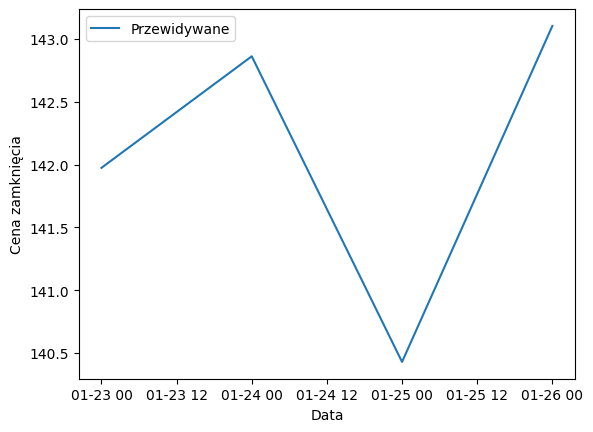

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


class MyARIMA:
    sc_in = MinMaxScaler(feature_range=(0, 1))
    sc_out = MinMaxScaler(feature_range=(0, 1))

    def __init__(self, args):
        self.train_size = -1
        self.test_size = -1
        self.order = tuple(map(int, args.order.split(', ')))

    def fit(self, data_x):
        data_x = np.array(data_x)
        train_x = data_x[:, 1:-1]  # Exclude the 'Date' and 'Next_Close' column
        train_y = data_x[:, -1]
        self.train_size = train_x.shape[0]
        train_x = self.sc_in.fit_transform(train_x)
        train_y = train_y.reshape(-1, 1)
        train_y = self.sc_out.fit_transform(train_y)
        train_x = np.array(train_x, dtype=float)
        train_y = np.array(train_y, dtype=float).flatten()
        self.model = ARIMA(train_y, exog=train_x, order=self.order)
        self.result = self.model.fit()

    def predict_future(self, test_x, steps=4):
        # Użyj danych testowych na 4 dni, aby dopasować do liczby kroków
        test_x = np.array(test_x[["Open", "High", "Low", "Volume"]], dtype=float)[:steps]  # Use only `steps` rows
        test_x = self.sc_in.transform(test_x)  # Scale the test features

        # Predict future prices using ARIMA model
        future_preds = self.result.forecast(steps=steps, exog=test_x)

        # Reshape and inverse transform the predictions to get them back to the original scale
        future_preds = future_preds.reshape(-1, 1)
        future_preds = self.sc_out.inverse_transform(future_preds)
        return future_preds


# 1. Pobierz dane historyczne z Yahoo Finance
data = yf.download('AAPL', start='2020-01-01', end='2023-01-31')
data.reset_index(inplace=True)
data['Next_Close'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Przygotowanie danych do modelu ARIMA
features = ['Open', 'High', 'Low', 'Volume']
target = ['Next_Close']
input_data = pd.concat([data['Date'], data[features], data[target]], axis=1)

# 2. Inicjalizacja i dopasowanie modelu ARIMA
args = type('', (), {})()  # Obiekt trzymający argumenty
args.order = '1, 0, 1'  # Ustawienia ARIMA (p, d, q)
model = MyARIMA(args)

# Dopasowanie modelu do danych historycznych (pomijając kolumnę 'Date')
model.fit(input_data)

# 3. Wybierz ostatnie dane do predykcji (tylko ostatnie 4 dni)
test_data = data.iloc[-5:]  # Wybieramy ostatnie 5 dni
test_data_for_prediction = test_data.iloc[:-1]  # Używamy tylko 4 wierszy do predykcji

# 4. Przewiduj przyszłe wartości (na kolejne 4 dni)
future_steps = 4  # Zmniejszamy liczbę dni do przewidywania
predicted_future = model.predict_future(test_data_for_prediction, steps=future_steps)

# 5. Pobierz rzeczywiste dane na przyszłość, aby porównać z predykcjami
# (ten fragment jest zakomentowany, ale można odkomentować, jeśli pobieramy rzeczywiste dane)
future_data = yf.download('AAPL', start='2023-02-01', end='2023-02-05')  # Pobieramy dane na 4 dni
future_data.reset_index(inplace=True)
actual_future_prices = future_data['Close'].values[:future_steps]

# 6. Porównaj przewidywane ceny z rzeczywistymi
print("Przewidywane ceny:", predicted_future.flatten())
print("Rzeczywiste ceny:", actual_future_prices)

# 7. Narysuj wykres porównujący przewidywane i rzeczywiste ceny
# (Zakomentowane, bo porównujemy tylko przewidywane ceny)
# plt.plot(future_data['Date'][:future_steps], actual_future_prices, label='Rzeczywiste')
plt.plot(test_data['Date'][:future_steps], predicted_future[:future_steps], label='Przewidywane')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.legend()
plt.show()
